#  Scalar Singlet Dark Matter

Get the binary files ready for SPheno and Micromegas according the instructions in https://github.com/restrepo/myslides/blob/2019_SARAH/sarah.pdf

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import os, sys, inspect
import commands3
from hep import *

## Benchmark point

In [3]:
a=hep(MODEL='SSDM')
#devnull=commands.getoutput('rm -f SPheno.spc.%s' %a.MODEL)

Check `a.config` for proper configurations.

In [4]:
a.LHA.blocks['MINPAR']

MINPAR { 1 : 2.8000000E-01   # Lambda1IN; 2 : 1.0000000E-02   # LamSHIN; 3 : 0.0000000E+00   # LamSIN; 4 : 2.0000000E+02   # MSinput }

In [5]:
a.LHA.blocks['MINPAR'][1]='2.6000000E-01   # Lambda1IN'
a.LHA.blocks['MINPAR'][2]='1.0000000E-02   # LamSHIN'
a.LHA.blocks['MINPAR'][4]='2.5000000E+03   # MSinput'

Run SPheno

In [6]:
spc=a.runSPheno()

Check output with float values

In [7]:
a.LHA_out.blocks['MASS'][25]

125.548349

Check output with string values

In [8]:
a.LHA_out_with_comments.blocks['MASS'][25]

'1.25548349E+02  # hh'

In [9]:
a.LHA_out_with_comments.blocks['FLAVORKITLFV'][701]

'0.00000000E+00  # BR(mu->e gamma)'

Process branchings and fill `a.Br` and `a.Br_names`

In [10]:
kk=a.branchings(a.LHA_out.decays,min_pdg=25)

In [11]:
a.Br[25][-3,3]

0.000172565229

In [12]:
a.Br_names['h0 ->  BBAR B']

0.462222579

Run micromegas (SPheno is also run automatically)

In [13]:
moc=a.runmicromegas(Direct_Detection=True,ddcmd='CalcOmega_with_DDetection_MOv5')

Check micromegas Output

In [14]:
a.Series.Omega_h2

0.0184

In [15]:
a.Series.proton_SI

7.066e-10

## Parameter scan

In [16]:
import pandas as pd
import numpy as np

Get experimental values of $\Omega_{\text{DM}}h^2$

In [17]:
dfs=pd.read_html('https://en.wikipedia.org/wiki/Lambda-CDM_model#Parameters')

In [18]:
Ωh2_exp=dfs[4]['Value'][1].split('±')
Ωh2_exp=[eval(x) for x in Ωh2_exp]
Ωh2_exp

[0.1188, 0.001]

Use physical singlet scalar mass as an input parameter
$$
m_S^2=M_S^2+\lambda_{HS} v^2
$$
$$
M_S^2=m_S^2-\lambda_{HS} v^2
$$

In [23]:
def get_Ωh2(xx):
    a.LHA.blocks['MINPAR'][2]=f'{xx}   # LamSHIN'
    moc=a.runmicromegas(Direct_Detection=True,ddcmd='CalcOmega_with_DDetection_MOv5')
    try:
        Ωh2=a.Series.Omega_h2
    except:
        Ωh2=float('NaN')
    return Ωh2

In [113]:
def search_Ωh2(λ_HS,Ωh2_exp,sign=+1,start=-2,end=1,NP=400,σs=3):
    '''
    Search for the proper relic density, 
    `Ωh2_exp` 
    within
    `σs`
    by increasing or decreasing 
    `λ_HS` 
    according to 
    `sign=+1` or `sign=-1` 
    respectively.
    `start` and `end` 
    are the logaλ variaton of `λ_HS` according to
    `λ_HS → λ_HS+sign*(10^(start),10^(end))` 
    with
    `NP` 
    points
    '''
    Ω=False
    l=[]
    increase=None
    #al=np.array([0])
    for xx in λ_HS+sign*λ_HS*np.logspace(start,1,NP):
        Ωh2=get_Ωh2(xx)
        if not np.isnan(Ωh2): 
            l.append(Ωh2)
        else:
            break
        if len(l)>0 and len(l)%10==0: #check every 10 steps
            increase=True
            #check only for the last 10
            ll=l[-10:]
            #print(ll)
            al=np.array(ll[1:])-np.array(ll[:-1])
            if False in [x>=0 for x in al]:
                increase=False
        #if list(al):
        #    print(increase==False ,len(al[al.round(6)!=0])>0 , Ωh2<Ωh2_exp[0]-σs*Ωh2_exp[1] )
        nround=6 # to check if it is really changing
        if increase and len(al[al.round(nround)!=0])>0 and Ωh2>Ωh2_exp[0]+σs*Ωh2_exp[1]:# → Problem
            sign=-sign
            break
        if increase==False and len(al[al.round(nround)!=0])>0 and Ωh2<Ωh2_exp[0]-σs*Ωh2_exp[1]:# → Problem
            sign=-sign
            break            
        print(f'{i} → λ_HS = {λ_HS} → {round(xx,8)}: Ωh²→ {round(Ωh2,4)}',increase,end='\r')
        if (Ωh2>Ωh2_exp[0]-σs*Ωh2_exp[1] and  
            Ωh2<Ωh2_exp[0]+σs*Ωh2_exp[1]):
            Ω=True
            λ_HS=xx
            break
    return λ_HS,Ω,Ωh2,sign

In [ ]:
l=[]
i=0
λ_HS=7.900000E-02
for mS2 in np.logspace(np.log10(40**2),np.log10(1000**2),50):#np.logspace(np.log10(40**2),np.log10(1000**2),10):
    #===CONFIG====
    Ω=False
    NP=400
    start=-2
    end=1
    sign=+1  
    σs=3
    λ_HSold=λ_HS #original
    #==============
    MS2=mS2-λ_HS*a.vev**2
    a.LHA.blocks['MINPAR'][2]=f'{λ_HS}   # LamSHIN'
    a.LHA.blocks['MINPAR'][4]=f'{MS2}   # MSinput'
    λ_HS,Ω,Ωh2,sign=search_Ωh2(λ_HS,Ωh2_exp,sign=sign,start=start,end=end,NP=NP,σs=σs) #(1)
    if not Ω: #Try the other way with opposite sign
        λ_HS=λ_HSold #recover intial λ_HS
        λ_HS,Ω,Ωh2,sign=search_Ωh2(λ_HS,Ωh2_exp,sign=sign,start=start,end=end,NP=NP,σs=σs) #(2)
    #Ω True after (1) or (2)
    if Ω:
        λ_HSold=λ_HS
        l.append({'MS2':a.LHA.blocks['MINPAR'][4],
                  'λ_HS':a.LHA_out.blocks['MINPAR'][2],
                  'M_DM':a.LHA_out.blocks['MASS'][6666635],                  
                  'Ω_h2':Ωh2,
                  'σSI':a.Series.proton_SI})
    else:
        λ_HS=λ_HSold #recover intial λ_HS
    print(i)
    #if i==60:
    #    break
    i=i+1
    #break

In [116]:
df=pd.DataFrame(l)

Text(0, 0.5, '$\\lambda_{HS}$')

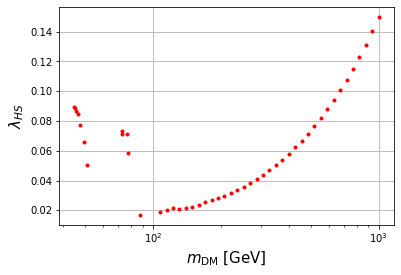

In [130]:
plt.semilogx(df.M_DM,df.λ_HS,'r.')
plt.grid()
plt.xlabel(r'$m_{\rm{DM}}$ [GeV]',size=15)
plt.ylabel(r'$\lambda_{HS}$',size=15)

Text(0, 0.5, '$\\sigma^{\\rm{SI}}$  [pb]')

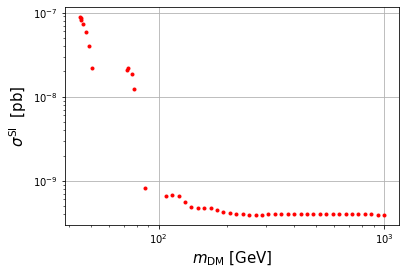

In [132]:
plt.loglog(df.M_DM,df.σSI,'r.')
plt.grid()
plt.xlabel(r'$m_{\rm{DM}}$ [GeV]',size=15)
plt.ylabel(r'$\sigma^{\rm{SI}}$  [pb]' ,size=15)